# 1. Introduction

Treves Li

UC Berkeley

2025-12-09

Create 3D digital twin of hillslope and colluvium at the Big C. Clustering interpolated EM results.

# 2. Setup and Imports

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pathlib import Path

# Set root path
import sys
root_path = Path.cwd().parents[0]
sys.path.append(str(root_path / "code"))

# Modelling libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture

# Visualiaation libraries
import pyvista as pv
from viz_helpers import voxelise_csv, plot_3d_voxel, plot_curtain_slice

# GIS helpers
# from common_utils.gis_helpers import em_inv2paraview, extract_elev_from_dem, filter_pred_intersect, format_csv2pointcloud
# from common_utils.emagpy_helpers import plot_inv_em_xsection
# from viz_helpers import voxelise_csv, plot_3d_voxel, plot_curtain_slice

# Plotting defaults
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [2]:
df = pd.read_csv(root_path / "data" / "processed" / "20251123_em_processed" / "1437_processed_inv_doi_kriged_0pt5_cropped.csv")

# 3. Cluster Points to Classify Colluvium

For detecting colluvium, resistivity is the most important, then maybe `z`. If we also cluster by x/y coordinates, otherwise clustering may be biased by spatial spread.

We can still include `x` and `y`, if we scale features to make all features comparable, since Euclidean distance is dominated by the **largest-scale feature**. After scaling, all features should then contribute equally.

Further, resistivity often spans orders of magnitude, so working in linear scale can bias clustering. The solution is to clustering in log scale, to make differences in resistivity more meaningful.

In [3]:
df = df[df['resistivity'] > 0].copy()  # Disregard negative resistivities
df['log_resistivity'] = np.log10(df['resistivity'])
# features = df[['x', 'y', 'z', 'log_resistivity']].copy()
features = df[['log_resistivity']].copy() # Try only clustering on resistivity

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

Clustering algorithms:

* **K-Means**: Not ideal, since colluvium may be elongated along slope
* **Gaussian**: may struggle with irregular shapes
* **DBSCAN**: density-based, good for irregular shapes, no need to predefine number of clusters, but needs careful tuning of parameters

However, we know we generally want 2 or 3 clusters (colluvium, not colluvium, transitional), so while DBSCAN is great for irregular shapes, it's ideal if we want exactly 2 or 3 clusters.
What we can try is to first use DBSCAN first to detect irregular dense patches. Then merge small clusters to create 2-3 mega-clusters based on mean resistivity or depth.

## DBSCAN

Hyperparameter tuning for DBSCAN:
* Main parameters are `eps` and `min_samples`
* `min_samples = 2*D` as a rule of thumb, where `D` is the number of dimensions. From [reddit](https://www.reddit.com/r/datascience/comments/5sfj0y/hdbscan_cluster_still_unclear_to_me_how_to_chose/ddfabms/): "5 to 15 isn't bad"
* For `eps`, we can use a k-distance graph to find the "elbow" point

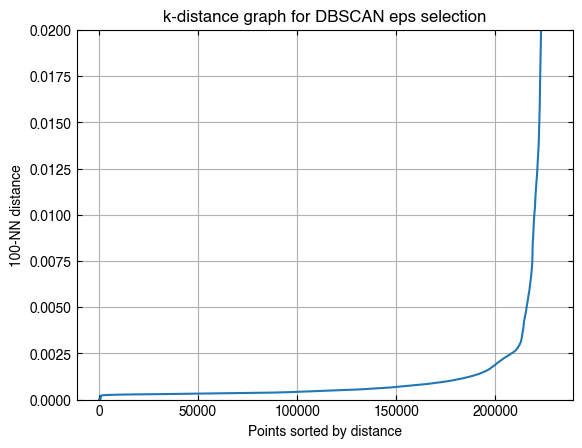

In [95]:
# Hyperparameter tune over `eps` and `min_samples`
min_samples = 100  # starting guess
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(features_scaled)
distances, indices = neighbors_fit.kneighbors(features_scaled)

# Take the distance to the k-th neighbor for each point
k_distances = np.sort(distances[:, -1])
plt.plot(k_distances)
plt.ylabel(f'{min_samples}-NN distance')
plt.xlabel('Points sorted by distance')
plt.title('k-distance graph for DBSCAN eps selection')
plt.ylim(0, 0.02)
plt.grid()
plt.show()

Select `eps` based on the elbow of the above figure.

In [97]:
# Fit DBSCAN
db = DBSCAN(eps=0.02, min_samples=100)
labels = db.fit_predict(features_scaled)
df['cluster'] = labels
df.to_csv(root_path / 'data' / 'processed' / '20251123_em_processed' / "1427_clustered_dbscan.csv", index=False)

print(df['cluster'].value_counts())

cluster
 0    223156
-1      3885
 1       123
 5       111
 2       102
 3       101
 4       100
Name: count, dtype: int64


## Gaussian Mixture Model

Choosing a cluster of 3 is admittedly based on judgment. We expect a priori that there will be colluvium, bedrock, and some kind of transition zone between which would have fractures.

In [41]:
# Number of clusters 
n_clusters = 3

# Fit GMM
gmm = GaussianMixture(n_components=n_clusters, covariance_type='diag', random_state=42, weights_init=[0.2, 0.2, 0.6])
gmm.fit(features_scaled)

# Predict hard cluster labels
labels_gmm = gmm.predict(features_scaled)

# Get probabilities for soft assignments
probs = gmm.predict_proba(features_scaled)  # shape (n_samples, n_clusters)

df['cluster'] = labels_gmm
df.to_csv(root_path / 'data' / 'processed' / '20251123_em_processed' / "1427_clustered_gmm.csv", index=False)

# Quick stats
print(df['cluster'].value_counts())

cluster
0    149594
2     70385
1      7599
Name: count, dtype: int64


In [24]:
# Threshold you want to apply
threshold = 0.8

# Find the max probability and corresponding cluster for each point
max_prob = probs.max(axis=1)
max_idx = probs.argmax(axis=1)

# Assign only if max probability exceeds threshold, else -1 (unassigned/noise)
labels_thresholded = np.where(max_prob >= threshold, max_idx, -1)

# Save back to dataframe
df['cluster'] = labels_thresholded

# Optional: check counts
print(df['cluster'].value_counts())


cluster
 0    144689
-1     41921
 2     35235
 1      5733
Name: count, dtype: int64


# 4. Visualise Clusters

In [46]:
# Create a PyVista point cloud
points = df[['x','y','z']].values
clusters = df['cluster'].values

# Optional: assign a color map for 3 clusters
# You can define a discrete color map with RGB tuples
cluster_colors = {
    -1: [200, 200, 200],  # gray for noise
    0: [255, 0, 0],     # red
    1: [0, 255, 0],     # green
    2: [0, 0, 255]      # blue
}

# Map cluster to RGB
colors = np.array([cluster_colors[c] for c in clusters])

# Create PyVista point cloud
cloud = pv.PolyData(points)
cloud["colors"] = colors / 255.0  # PyVista expects 0-1 floats for RGB

# Plot
plotter = pv.Plotter()
plotter.add_points(cloud, scalars="colors", rgb=True, point_size=5)
plotter.show_grid()  # optional
# plotter.show()


<CubeAxesActor(0x000001B123D6A810) at 0x000001B17784C100>

Identify colluvium cluster by compare cluster statistics: mean resistivity, depth, spread.

Colluvium usually has low resistivity and shallow depth, so you can assign cluster labels to “likely colluvium.”

In [38]:
df.groupby('cluster')['resistivity'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
-1,86785.0,107.612354,429.380574,0.276470,51.758666,62.830435,84.373854,29186.411940
0,140299.0,36.963735,6.442554,20.486399,32.571211,36.542388,41.020649,65.393461
1,223.0,52.573818,1.832356,48.584609,51.187014,52.740520,53.933361,56.096155
2,271.0,75.015505,2.712822,70.479039,73.296324,74.053862,76.418824,80.930876


# 5. Slice Along Clustered Data

In [43]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

def plot_curtain_slice_classified(df, x1, y1, x2, y2, avg_doi,
                                  title=None, tol=1.0, dz=0.1,
                                  dx_bin=1.0, cluster_colors=None):
    """
    Plot a smooth vertical curtain slice from scattered 3D points,
    colored by cluster labels (integers). Legend is shown as colored dots.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must have ['x','y','z','cluster'].
    x1, y1, x2, y2 : float
        Coordinates of the slice line.
    avg_doi : float
        Maximum allowed extrapolation below measured z.
    tol : float
        Distance tolerance around slice line (meters).
    dz : float
        Vertical resolution (meters).
    dx_bin : float
        Horizontal bin width along the slice (meters).
    cluster_colors : dict, optional
        Mapping from cluster integer to RGB or named color.
        Noise cluster (-1) should be included if present.
    title : str
        Plot title.
    """
    
    if cluster_colors is None:
        # Default colors for clusters 0,1,2 and noise -1
        cluster_colors = {
            -1: 'lightgray',
            0: 'red',
            1: 'green',
            2: 'blue'
        }
    
    # Compute slice unit vector
    dx, dy = x2 - x1, y2 - y1
    line_len = np.hypot(dx, dy)
    ux, uy = dx / line_len, dy / line_len

    # Project points onto line
    rel_x = df['x'] - x1
    rel_y = df['y'] - y1
    dist_along = rel_x * ux + rel_y * uy
    dist_perp = np.abs(-dy*rel_x + dx*rel_y) / line_len

    # Keep points near slice
    mask = (dist_perp <= tol) & (dist_along >= 0) & (dist_along <= line_len)
    slice_df = df.loc[mask].copy()
    if slice_df.empty:
        print("No points found along slice.")
        return

    # Bin points horizontally
    slice_df['dist_bin'] = (slice_df['x']*ux + slice_df['y']*uy) / dx_bin
    slice_df['dist_bin'] = np.round(slice_df['dist_bin']) * dx_bin
    unique_dist = np.sort(slice_df['dist_bin'].unique())
    unique_dist_rel = unique_dist - unique_dist.min()

    # Vertical grid
    z_min = slice_df['z'].min()
    z_max = slice_df['z'].max() + avg_doi
    z_grid = np.arange(z_min, z_max + dz, dz)
    grid_values = np.full((len(z_grid), len(unique_dist)), np.nan)

    # Interpolate cluster per horizontal bin
    for i, d in enumerate(unique_dist):
        col_df = slice_df[slice_df['dist_bin'] == d]
        if not col_df.empty:
            # Assign most frequent cluster in the bin at each z
            for j, z in enumerate(z_grid):
                idx = np.abs(col_df['z'] - z) <= dz/2
                if idx.any():
                    cluster_val = col_df.loc[idx, 'cluster'].mode()[0]
                    grid_values[j, i] = cluster_val

    # Define colormap
    clusters_present = np.unique(slice_df['cluster'])
    colors_list = [cluster_colors.get(c, 'black') for c in clusters_present]
    cmap = mcolors.ListedColormap(colors_list)
    bounds = np.arange(min(clusters_present)-0.5, max(clusters_present)+1.5, 1)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Plot
    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.pcolormesh(unique_dist_rel, z_grid, grid_values,
                       shading='auto', cmap=cmap, norm=norm)

    # Legend as colored dots
    legend_elements = [Patch(facecolor=cluster_colors.get(c, 'black'),
                             edgecolor='k',
                             label=f'Cluster {int(c)+1}' if c != -1 else 'Noise')
                       for c in clusters_present]
    ax.legend(handles=legend_elements, loc='upper right')

    ax.set_xlabel('Distance along slice (m)')
    ax.set_ylabel('Elevation (m)')
    ax.set_title(title or 'Curtain Slice Classified by Cluster')
    ax.set_ylim(z_grid.min(), z_grid.max())
    ax.set_aspect('equal')
    plt.show()

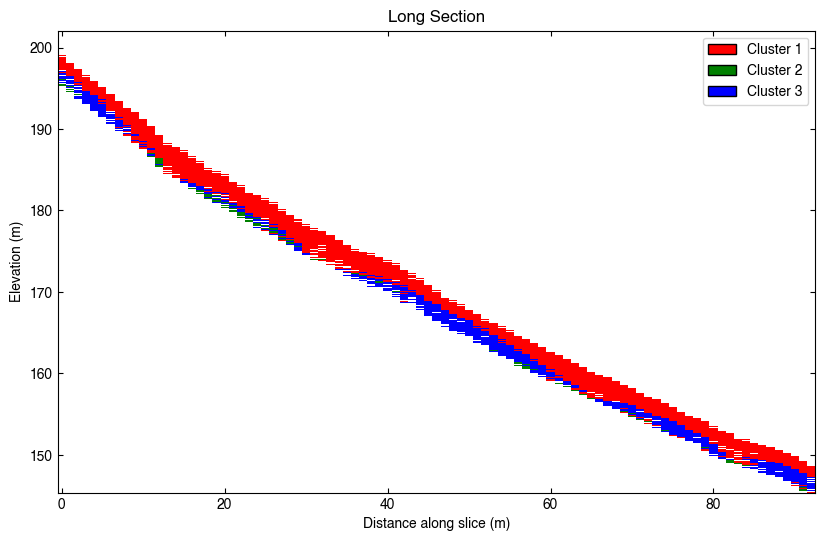

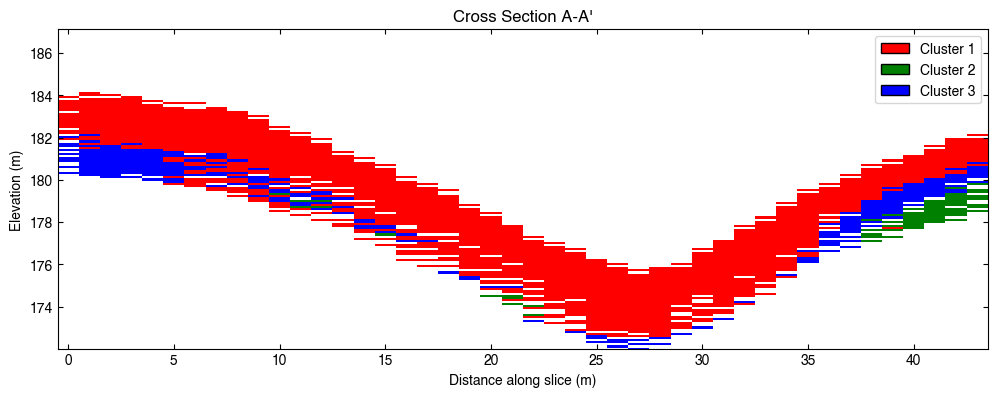

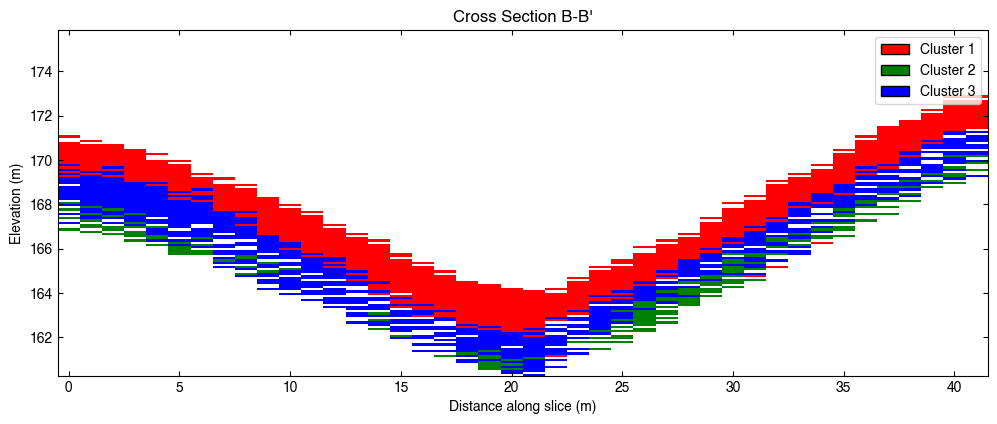

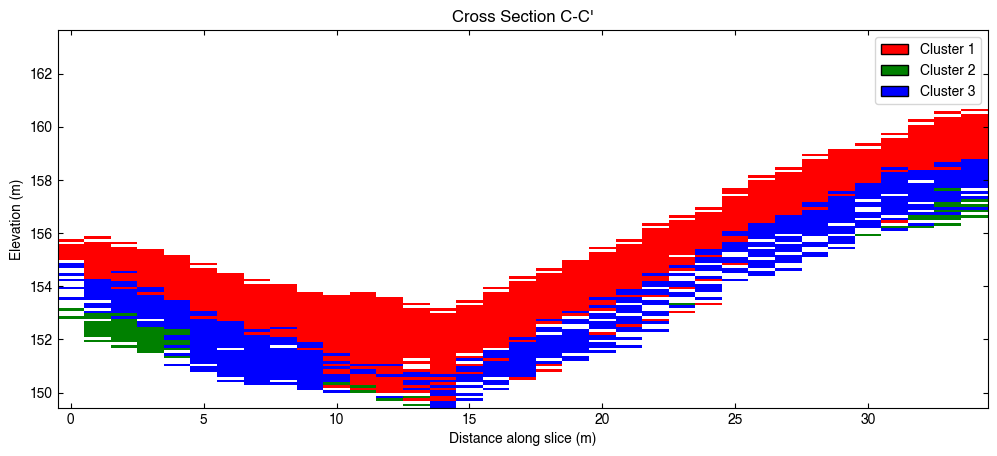

In [44]:
# Average DOI
avg_doi = 3.0

# # Long Section
plot_curtain_slice_classified(df, 
                   x1=565929.0, y1=4192172.6,
                   x2=565844.7, y2=4192092.2,
                   title="Long Section",
                   avg_doi=avg_doi)

# # Cross Section 1 (Upper A-A')
plot_curtain_slice_classified(df, 
                   x1=565876.0, y1=4192162.7,
                   x2=565917.2, y2=4192125.0,
                   title="Cross Section A-A'",
                   avg_doi=avg_doi)

# # # Cross Section 2 (Mid B-B')
plot_curtain_slice_classified(df, 
                   x1=565846.7, y1=4192156.6,
                   x2=565910.9, y2=4192100.3,
                   title="Cross Section B-B'",
                   avg_doi=avg_doi)

# # # Cross Section 2 (Lower C-C')
plot_curtain_slice_classified(df, 
                   x1=565838.5, y1=4192132.9,
                   x2=565894.3, y2=4192082.2,
                   title="Cross Section C-C'",
                   avg_doi=avg_doi)